In [1]:
import os, sys
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import torch
import pandas as pd 

# 0. Prepare Data

### Training data includes the following gesture recordings from subject_1 at neutral wearing locations
* rest
* wrist flexion (WF)
* forearm pronation and wrist extension (FP & WE)
* radial deviation (RD)
* ulnar deviation (UD)

Check `train_for_ros_myo_one_subject.ipynb` for details.

In [2]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG_myo")
from PrepareAndLoadData.process_data import read_data_training

In [3]:
data_dir = "/home/laiy/gitrepos/msr_final/Wearable_Sensor_Long-term_sEMG_Dataset/data"
processed_data_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Processed_datasets_ros"

path_TSD ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_ros/TSD"
save_TSD = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

In [19]:
# read_data_training(path=data_dir, store_path = processed_data_dir, num_participant=1, include_gestures = [1,2,10,4,5])

In [5]:
# check stored pickle 
with open(processed_data_dir + "/training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train = dataset_training['examples_training']
print('traning examples ', np.shape(examples_datasets_train))
labels_datasets_train = dataset_training['labels_training']
print('traning labels ', np.shape(labels_datasets_train))

# 26 * 5 = 130 examples for each dataset

traning examples  (1, 3, 40, 130, 252)
traning labels  (1, 3, 40, 130)


In [6]:
num_kernels=[200, 200, 200]                        # model layer size 
number_of_cycles_total=np.shape(examples_datasets_train[0][0])[0]               # #session
print("number_of_cycles_total ", number_of_cycles_total)
number_of_classes=5
batch_size=128          
feature_vector_input_length=252                     # size of one example 
learning_rate=0.002515

number_of_cycles_total  40


# 1. TSD_DNN
* The trained model is used for classifying right forearm gestures in the `myo_ros` project

In [8]:
train_fine_tuning(examples_datasets_train, labels_datasets_train,
                  num_kernels=num_kernels, path_weight_to_save_to=path_TSD,
                  number_of_classes=number_of_classes, number_of_cycles_total=number_of_cycles_total,
                  batch_size=batch_size,
                  feature_vector_input_length=feature_vector_input_length,
                  learning_rate=learning_rate)

GET one participant_examples  (3, 40, 130, 252)
   GET one training_index_examples  (40, 130, 252)  at  0
   GOT one group XY  (5200, 252)    (5200,)
       one group XY test  (0,)    (0,)
       one group XY train (4680, 252)    (4680,)
       one group XY valid (520, 252)    (520, 252)
   GET one training_index_examples  (40, 130, 252)  at  1
   GOT one group XY  (5200, 252)    (5200,)
       one group XY test  (0,)    (0,)
       one group XY train (4680, 252)    (4680,)
       one group XY valid (520, 252)    (520, 252)
   GET one training_index_examples  (40, 130, 252)  at  2
   GOT one group XY  (5200, 252)    (5200,)
       one group XY test  (0,)    (0,)
       one group XY train (4680, 252)    (4680,)
       one group XY valid (520, 252)    (520, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 0)
START TRAINING
Participant:  0
Session:  0
<generator object Module.parameters at 0x7efe449e3740>
Epoch 0/499
----------
train Loss: 0.00185062 Acc: 0.93728299
val L

In [9]:
algo_name = "standard_TSD"
test_TSD_DNN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                                  num_neurons=num_kernels, use_only_first_training=True,
                                  path_weights=path_TSD,
                                  feature_vector_input_length=feature_vector_input_length,
                                  save_path = save_TSD, algo_name=algo_name,
                                  number_of_cycles_total=number_of_cycles_total,
                                  number_of_classes=number_of_classes, cycle_for_test=3)

GET one participant_examples  (3, 40, 130, 252)
   GET one training_index_examples  (40, 130, 252)  at  0
   GOT one group XY  (5200, 252)    (5200,)
       one group XY test  (1300, 252)    (1300, 252)
       one group XY train (4680, 252)    (4680,)
       one group XY valid (520, 252)    (520, 252)
   GET one training_index_examples  (40, 130, 252)  at  1
   GOT one group XY  (5200, 252)    (5200,)
       one group XY test  (1300, 252)    (1300, 252)
       one group XY train (4680, 252)    (4680,)
       one group XY valid (520, 252)    (520, 252)
   GET one training_index_examples  (40, 130, 252)  at  2
   GOT one group XY  (5200, 252)    (5200,)
       one group XY test  (1300, 252)    (1300, 252)
       one group XY train (4680, 252)    (4680,)
       one group XY valid (520, 252)    (520, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 3)
0  SESSION   data =  1300
Participant:  0  Accuracy:  0.9992307692307693
1  SESSION   data =  1300
Participant:  0  Accurac

In [10]:
results_filename = save_TSD + '/predictions_' + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
TSD_acc = results[0]
TSD_acc_overall = np.mean(TSD_acc)
TSD_df = pd.DataFrame(TSD_acc.transpose(), 
                       index = [f'Session_{i}' for i in range(TSD_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(TSD_acc.shape[0])])
TSD_df

,Participant_0
Session_0,0.999231
Session_1,0.907692
Session_2,0.969231


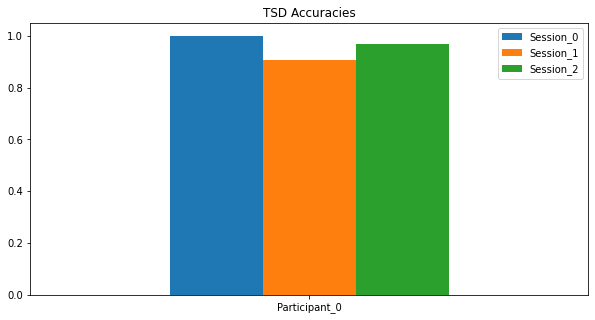

In [11]:
TSD_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("TSD Accuracies")
plt.show()

In [12]:
from TrainingsAndEvaluations.ForTrainingSessions.utils import get_gesture_accuracies

In [13]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Sub"
n_name = "Loc"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_TSD, algo_name=algo_name)
df = pd.read_csv(save_TSD+'/'+algo_name+'.csv')
df

ground_truths  =  (1, 3)
predictions =  (1, 3)
accuracies_gestures =  (5, 3)


,Unnamed: 0,Sub0_Loc0,Sub0_Loc1,Sub0_Loc2
0,M0,1.000000,1.000000,1.000000
1,M1,1.000000,0.846154,1.000000
2,M2,1.000000,1.000000,0.957692
3,M3,1.000000,0.757692,1.000000
4,M4,0.996154,0.934615,0.888462
5,Mean,0.999231,0.907692,0.969231


# 2. Test Model
Make sure the model can be saved and loaded. 

In [14]:
test_example = examples_datasets_train[0][0][0][-1]
test_label = labels_datasets_train[0][0][0][-1]

print("test_example ", np.shape(test_example))
print("test_label ", test_label)

test_example  (252,)
test_label  4.0


In [15]:
from Models.TSD_neural_network import TSD_Network

In [16]:
path_weights ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_ros/TSD/participant_0/best_state_0.pt"
num_kernels=[200, 200, 200]                        # model layer size 
number_of_classes=5
feature_vector_input_length=252                     # size of one example 

model = TSD_Network(number_of_class=number_of_classes, num_neurons=num_kernels,
                            feature_vector_input_length=feature_vector_input_length)

best_state = torch.load(path_weights)
best_weights = best_state['state_dict']
model.load_state_dict(best_weights)

<All keys matched successfully>

In [17]:
inputs  = torch.from_numpy(np.array([test_example], dtype=np.float32))
model.eval()
output = model(inputs)
_, predicted = torch.max(output.data, 1)
print("predicted = ", predicted.numpy()[0])
print("ground = ", test_label)

predicted =  4
ground =  4.0
